# Diagonal multi-omics integration - analysis of unmatched datasets 

In this notebook we will perform exploratory analysis and joint dimensionality reduction on unmatched scRNA-seq and scATAC-seq data of developing brain cortex from [Trevino et al.2020](https://www.biorxiv.org/content/10.1101/2020.12.29.424636v2.full), focusing on differentiation of excitatory glutamatergic neurons.

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy

import muon as mu
import anndata

## Plotting utils
import matplotlib.pyplot as plt
import matplotlib

Let's set up `rpy2` usage to use R functions and chunks within this python notebook and conversion between `anndata` and `SingleCellExperiment` objects with [`anndata2ri`](https://github.com/theislab/anndata2ri). 

In [3]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
import rpy2.rinterface_lib.callbacks
import logging

## Load single-omic data

We downloaded the original datasets following the instructions in https://github.com/GreenleafLab/brainchromatin, which we further cleaned, filtered and  converted to `anndata` objects saved in `.h5ad` files.

The data for each omic view is stored in [`AnnData`](https://anndata.readthedocs.io/en/latest/index.html) format. An `AnnData` object allows us to store a matrix and add annotations to its different dimensions, defined as “observations” (i.e. cells), and measured “variables” (i.e. genes for the RNA view and peaks for the ATAC modalities).

In [5]:
## Put the path to the data here
# # from AWS instance
# data_dir = "/data/multiomics/gr1_unmatched_diagonal"
## or
# data_dir = "/path/to/data/gr1_unmatched_diagonal"

In [5]:
rna_adata = sc.read_h5ad('{d}/scRNA_clean_SCE.h5ad'.format(d=data_dir))
atac_adata = sc.read_h5ad('{d}/processed_data/scATAC_clean_SCE.h5ad'.format(d=data_dir))

We can access the annotations on cells using `adata.obs` (cell type annotations are stored in `adata.obs["cluster_name"]`, while cells that belong to the glutamatergic neuron differentiation trajectory are marked in `adata.obs['in_GluN_trajectory']`)

In [7]:
rna_adata.obs

,Sample.ID,Age,Tissue.ID,Sample.Type,Batch,seurat_clusters,RNA.Counts,RNA.Features,Percent.MT,Percent.Ribo,Cell.Barcode,cluster_name,in_GluN_trajectory
hft_w16_p7_r1_AAACCCAAGTATTGCC,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c8,5748,2339,0.029749,0.202853,AAACCCAAGTATTGCC,Cyc. Prog.,False
hft_w16_p7_r1_AAACCCAAGTTCACTG,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c5,10640,3408,0.037027,0.183723,AAACCCAAGTTCACTG,GluN3,True
hft_w16_p7_r1_AAACCCACAAGAGTGC,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c5,6734,2729,0.031329,0.133036,AAACCCACAAGAGTGC,GluN3,True
hft_w16_p7_r1_AAACCCACAAGATTGA,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c7,5186,2393,0.104644,0.066294,AAACCCACAAGATTGA,GluN7,True
hft_w16_p7_r1_AAACCCACAGATGCGA,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c2,4689,2013,0.051386,0.178678,AAACCCACAGATGCGA,GluN1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r2_TTTGTTGCAGCACCCA,hft_w16_p7_r2,pcw16,HFT7,HFT,b2020_03,c6,8532,3497,0.018749,0.136396,TTTGTTGCAGCACCCA,Early RG,False
hft_w16_p7_r2_TTTGTTGCAGGCTACC,hft_w16_p7_r2,pcw16,HFT7,HFT,b2020_03,c2,6689,2393,0.045577,0.246862,TTTGTTGCAGGCTACC,GluN1,True
hft_w16_p7_r2_TTTGTTGGTCGCTTAA,hft_w16_p7_r2,pcw16,HFT7,HFT,b2020_03,c2,3865,1799,0.035954,0.159079,TTTGTTGGTCGCTTAA,GluN1,True
hft_w16_p7_r2_TTTGTTGGTCGTACAT,hft_w16_p7_r2,pcw16,HFT7,HFT,b2020_03,c2,5293,2365,0.032861,0.158074,TTTGTTGGTCGTACAT,GluN1,True


In [8]:
atac_adata.obs

,Sample.ID,Age,Tissue.ID,Sample.Type,Batch,Iterative.LSI.Clusters,Tss.Enrichment,Cell.Barcode,TSS.Enrichment.Unsmoothed,clusterID,cluster_name,cluster_name_long,Assay,in_GluN_trajectory
hft_w16_p7_r1_cell_1,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c11,19.157088,AAACGAAGTTTGTGAC-1,29.118774,c11,Early RG,Early Radial Glia,scATAC,False
hft_w16_p7_r1_cell_2,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c7,24.651890,AAACGAATCCCAATGA-1,39.130435,c7,GluN3,Glutamatergic Neuron 3,scATAC,True
hft_w16_p7_r1_cell_3,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c7,5.215686,AAACGAATCGTGGGTC-1,14.000000,c7,GluN3,Glutamatergic Neuron 3,scATAC,True
hft_w16_p7_r1_cell_5,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c6,29.726230,AAACGAATCTTGTCGC-1,43.396226,c6,GluN2,Glutamatergic Neuron 2,scATAC,True
hft_w16_p7_r1_cell_7,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c6,25.531414,AAACTCGAGGCTAAAT-1,43.243243,c6,GluN2,Glutamatergic Neuron 2,scATAC,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r3_cell_2860,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c8,20.657277,TTTGGTTGTGTCGTCG-1,36.056338,c8,nIPC,neuronal Intermedate Progenitor Cell,scATAC,True
hft_w16_p7_r3_cell_2862,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c11,15.333333,TTTGTGTAGGTTGTGG-1,32.000000,c11,Early RG,Early Radial Glia,scATAC,False
hft_w16_p7_r3_cell_2863,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c11,22.873213,TTTGTGTGTACTTCGA-1,46.215139,c11,Early RG,Early Radial Glia,scATAC,False
hft_w16_p7_r3_cell_2864,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c11,18.983297,TTTGTGTGTTCGGGAA-1,28.888889,c11,Early RG,Early Radial Glia,scATAC,False


We can access the annotation on features (genes for RNA modality, peaks for ATAC modality) with `adata.var`. Here we also store the genomic coordinates of the peaks and genes, which we will use later.

In [9]:
rna_adata.var["gene_ids"] = rna_adata.var.index.copy()
rna_adata.var

,gene_name,interval,gene_ids
ENSG00000243485,MIR1302-2,chr1-29554-31109,ENSG00000243485
ENSG00000237613,FAM138A,chr1-34554-36081,ENSG00000237613
ENSG00000186092,OR4F5,chr1-69091-70008,ENSG00000186092
ENSG00000238009,RP11-34P13.7,chr1-89295-133723,ENSG00000238009
ENSG00000239945,RP11-34P13.8,chr1-89551-91105,ENSG00000239945
...,...,...,...
ENSG00000212907,MT-ND4L,chrM-10470-10766,ENSG00000212907
ENSG00000198886,MT-ND4,chrM-10760-12137,ENSG00000198886
ENSG00000198786,MT-ND5,chrM-12337-14148,ENSG00000198786
ENSG00000198695,MT-ND6,chrM-14149-14673,ENSG00000198695


In [11]:
atac_adata.var

,seqnames,start,end,width,strand,name,classification
c2_peak_1,chr1,10028,10528,501,*,c2_peak_1,distal
c4_peak_1,chr1,180647,181147,501,*,c4_peak_1,distal
c6_peak_2,chr1,181234,181734,501,*,c6_peak_2,distal
c9_peak_2a,chr1,191218,191718,501,*,c9_peak_2a,distal
c1_peak_1,chr1,265926,266426,501,*,c1_peak_1,distal
...,...,...,...,...,...,...,...
c11_peak_130741,chr22,50775058,50775558,501,*,c11_peak_130741,genic
c12_peak_153317b,chr22,50783369,50783869,501,*,c12_peak_153317b,proximal
c7_peak_124670,chr22,50783886,50784386,501,*,c7_peak_124670,proximal
c12_peak_153318,chr22,50785216,50785716,501,*,c12_peak_153318,distal


## Build multi-modal `MuData` object

We now want to store both data objects for both modalities in a single object, to facilitate multi-modal analysis. Here we will use [`muon`](https://muon.readthedocs.io/en/latest/index.html), a python framework for multimodal data analysis with a strong focus on multi-omics.

`muon.MuData` is a multi-modal data container, that comprises a dictionary with `AnnData` objects, one per modality, in its `.mod` attribute. Just as `AnnData` objects themselves, they also contain attributes like `.obs` with annotation of observations (samples or cells), `.obsm` with their multidimensional annotations such as embeddings, etc.


In [12]:
mdata = mu.MuData({'rna': rna_adata, 'atac': atac_adata})

In [13]:
mdata

MuData object with n_obs × n_vars = 25796 × 691127
  2 modalities
    rna:	19373 x 33197
      obs:	'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'cluster_name', 'in_GluN_trajectory'
      var:	'gene_name', 'interval', 'gene_ids'
    atac:	6423 x 657930
      obs:	'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'Iterative.LSI.Clusters', 'Tss.Enrichment', 'Cell.Barcode', 'TSS.Enrichment.Unsmoothed', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
      var:	'seqnames', 'start', 'end', 'width', 'strand', 'name', 'classification'

In [15]:
mdata.mod

{'rna': AnnData object with n_obs × n_vars = 19373 × 33197
     obs: 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'cluster_name', 'in_GluN_trajectory'
     var: 'gene_name', 'interval', 'gene_ids',
 'atac': AnnData object with n_obs × n_vars = 6423 × 657930
     obs: 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'Iterative.LSI.Clusters', 'Tss.Enrichment', 'Cell.Barcode', 'TSS.Enrichment.Unsmoothed', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
     var: 'seqnames', 'start', 'end', 'width', 'strand', 'name', 'classification'}

You can see the object now concatenates `.obs` from both assays in a single object, and the info about the original assay for each column is saved

In [16]:
mdata.obs

,rna:Sample.ID,rna:Age,rna:Tissue.ID,rna:Sample.Type,rna:Batch,rna:seurat_clusters,rna:RNA.Counts,rna:RNA.Features,rna:Percent.MT,rna:Percent.Ribo,...,atac:Batch,atac:Iterative.LSI.Clusters,atac:Tss.Enrichment,atac:Cell.Barcode,atac:TSS.Enrichment.Unsmoothed,atac:clusterID,atac:cluster_name,atac:cluster_name_long,atac:Assay,atac:in_GluN_trajectory
hft_w16_p7_r1_AAACCCAAGTATTGCC,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c8,5748.0,2339.0,0.029749,0.202853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w16_p7_r1_AAACCCAAGTTCACTG,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c5,10640.0,3408.0,0.037027,0.183723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w16_p7_r1_AAACCCACAAGAGTGC,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c5,6734.0,2729.0,0.031329,0.133036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w16_p7_r1_AAACCCACAAGATTGA,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c7,5186.0,2393.0,0.104644,0.066294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w16_p7_r1_AAACCCACAGATGCGA,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c2,4689.0,2013.0,0.051386,0.178678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r3_cell_2860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b2020_03,c8,20.657277,TTTGGTTGTGTCGTCG-1,36.056338,c8,nIPC,neuronal Intermedate Progenitor Cell,scATAC,True
hft_w16_p7_r3_cell_2862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b2020_03,c11,15.333333,TTTGTGTAGGTTGTGG-1,32.000000,c11,Early RG,Early Radial Glia,scATAC,False
hft_w16_p7_r3_cell_2863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b2020_03,c11,22.873213,TTTGTGTGTACTTCGA-1,46.215139,c11,Early RG,Early Radial Glia,scATAC,False
hft_w16_p7_r3_cell_2864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b2020_03,c11,18.983297,TTTGTGTGTTCGGGAA-1,28.888889,c11,Early RG,Early Radial Glia,scATAC,False


Observations and variables of the `MuData` object are global, which means that observations with the identical name (`.obs_names`) in different modalities are considered to be the same observation. This also means variable names (`.var_names`) should be unique.

Notably, individual modalities inside the MuData container are stored as references to the original objects and are full-fledged AnnData objects, which can be operated independently with any tool that works on AnnData objects. So if we change the single-omic `AnnData` objects, the changes will be reflected in the container.

For example, if we add a column to the `.obs` of the RNA modality object, we can see the new column is also accessible from the container.


In [17]:
rna_adata.obs["new_col"] = 0
mdata["rna"]

AnnData object with n_obs × n_vars = 19373 × 33197
    obs: 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'cluster_name', 'in_GluN_trajectory', 'new_col'
    var: 'gene_name', 'interval', 'gene_ids'

However, the column is not found in the common `.obs`

In [18]:
"rna:new_col" in mdata.obs.columns

False

To update the common obs, we can use the `.update_obs()` method, that syncs up the data.

In [19]:
mdata.update_obs()
mdata.obs["rna:new_col"]

hft_w16_p7_r1_AAACCCAAGTATTGCC    0.0
hft_w16_p7_r1_AAACCCAAGTTCACTG    0.0
hft_w16_p7_r1_AAACCCACAAGAGTGC    0.0
hft_w16_p7_r1_AAACCCACAAGATTGA    0.0
hft_w16_p7_r1_AAACCCACAGATGCGA    0.0
                                 ... 
hft_w16_p7_r3_cell_2860           NaN
hft_w16_p7_r3_cell_2862           NaN
hft_w16_p7_r3_cell_2863           NaN
hft_w16_p7_r3_cell_2864           NaN
hft_w16_p7_r3_cell_2865           NaN
Name: rna:new_col, Length: 25796, dtype: float64

To update everything we can use `mdata.update()`

## Preprocessing and exploration of RNA modality

We can start preprocessing and exploring the RNA data, using the standard functions implemented in `scanpy`. 

In this case cells have already been filtered by percentage of mitochrondrial counts and total counts, so we start by filtering genes.

In [25]:
sc.pp.filter_genes(rna_adata, min_cells=3)

Then we normalize and log-transform the raw counts

In [26]:
sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.log1p(rna_adata)

We identify highly variable genes for dimensionality reduction

In [27]:
sc.pp.highly_variable_genes(rna_adata,min_mean=0.0125, max_mean=3, min_disp=0.5)

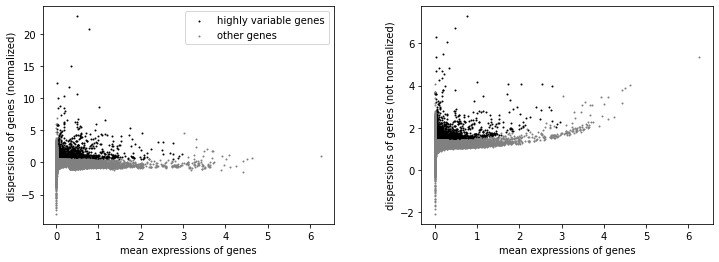

In [28]:
sc.pl.highly_variable_genes(rna_adata)

Let's check how many genes are identified as highly variable

In [29]:
np.sum(rna_adata.var.highly_variable)

2365

Next we run dimensionality reduction with PCA and use PCs to construct a K-nearest neighbor graph for visualization of our cells in UMAP

In [30]:
sc.pp.pca(rna_adata)
sc.pp.neighbors(rna_adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(rna_adata)

In [31]:
rna_adata

AnnData object with n_obs × n_vars = 19373 × 21906
    obs: 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'cluster_name', 'in_GluN_trajectory', 'new_col'
    var: 'gene_name', 'interval', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

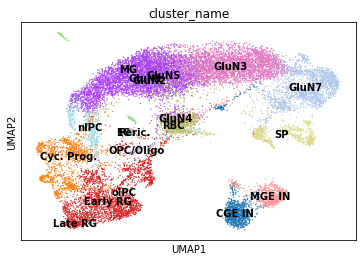

In [38]:
sc.pl.umap(rna_adata, color=["cluster_name"], legend_loc="on data")

We can see differences in expression of known marker genes for neuronal intermediate progenitor cells (nIPC) and different stages of differentiation of glutamatergic excitatory neurons (GluN).

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['RP11-34P13.7', 'RP11-206L10.9', 'FAM87B', 'LINC00115', 'FAM41C']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


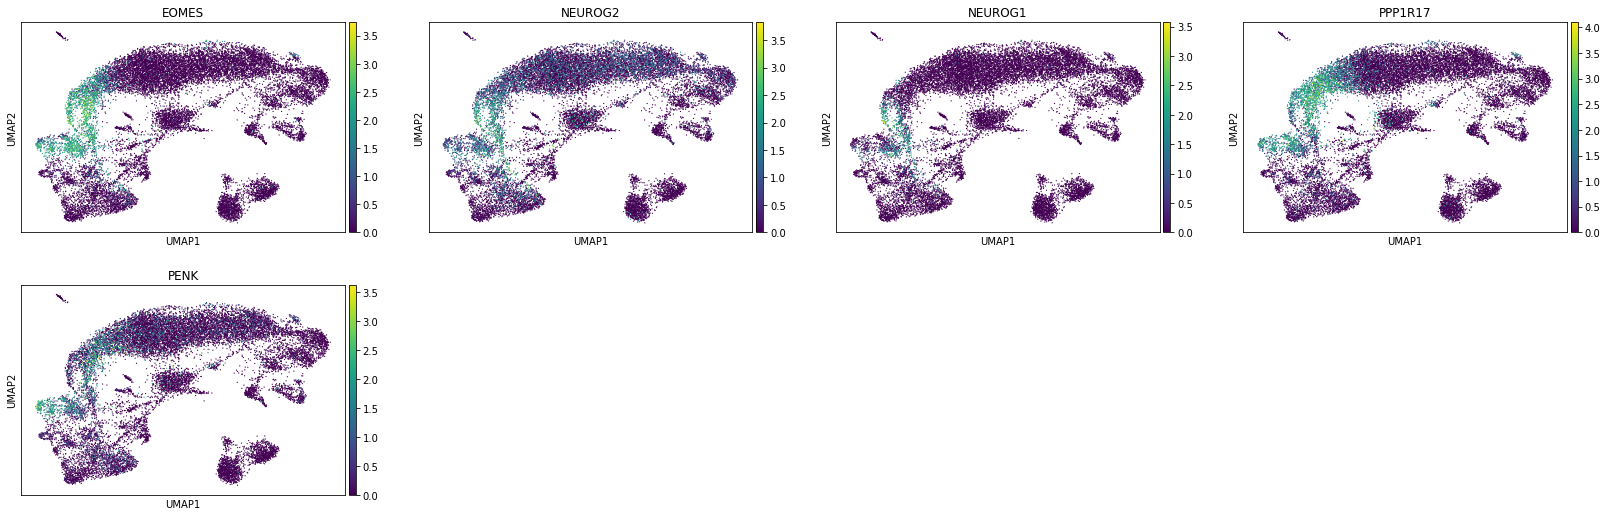

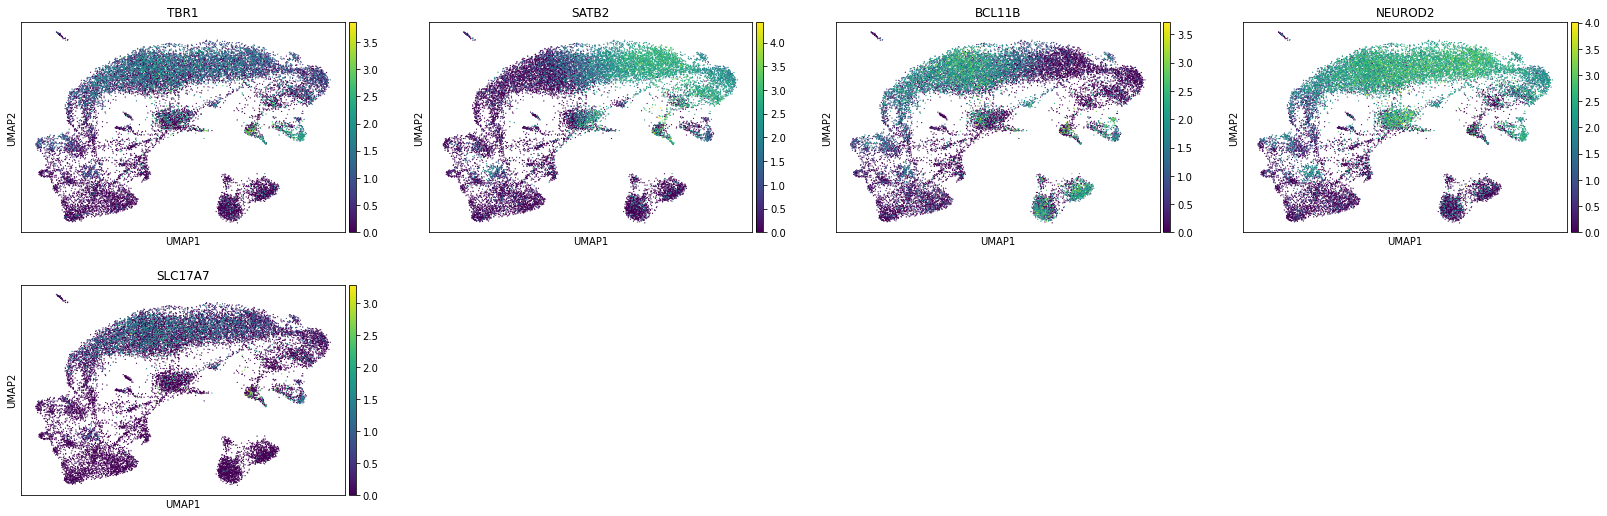

In [39]:
marker_genes = {
    "nIPC":['EOMES', 'PPP1R17', 'PENK', 'NEUROG1', 'NEUROG2'],
    "GluN":['NEUROD2', 'TBR1', 'BCL11B', 'SATB2', 'SLC17A7']
               }

rna_adata.var_names = rna_adata.var["gene_name"].values.copy()
sc.pl.umap(rna_adata, color=rna_adata.var_names[rna_adata.var_names.isin(marker_genes["nIPC"])])
sc.pl.umap(rna_adata, color=rna_adata.var_names[rna_adata.var_names.isin(marker_genes["GluN"])])

We can use ordinary [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971) to order excitatory neurons along a differentiation trajectory stemming from the nIPCs. 

In [40]:
## Subset to glutamatergic neurons
ext_rna_adata = rna_adata[rna_adata.obs["in_GluN_trajectory"]].copy()
sc.pp.pca(ext_rna_adata)
sc.pp.neighbors(ext_rna_adata, n_neighbors=10, n_pcs=30)

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


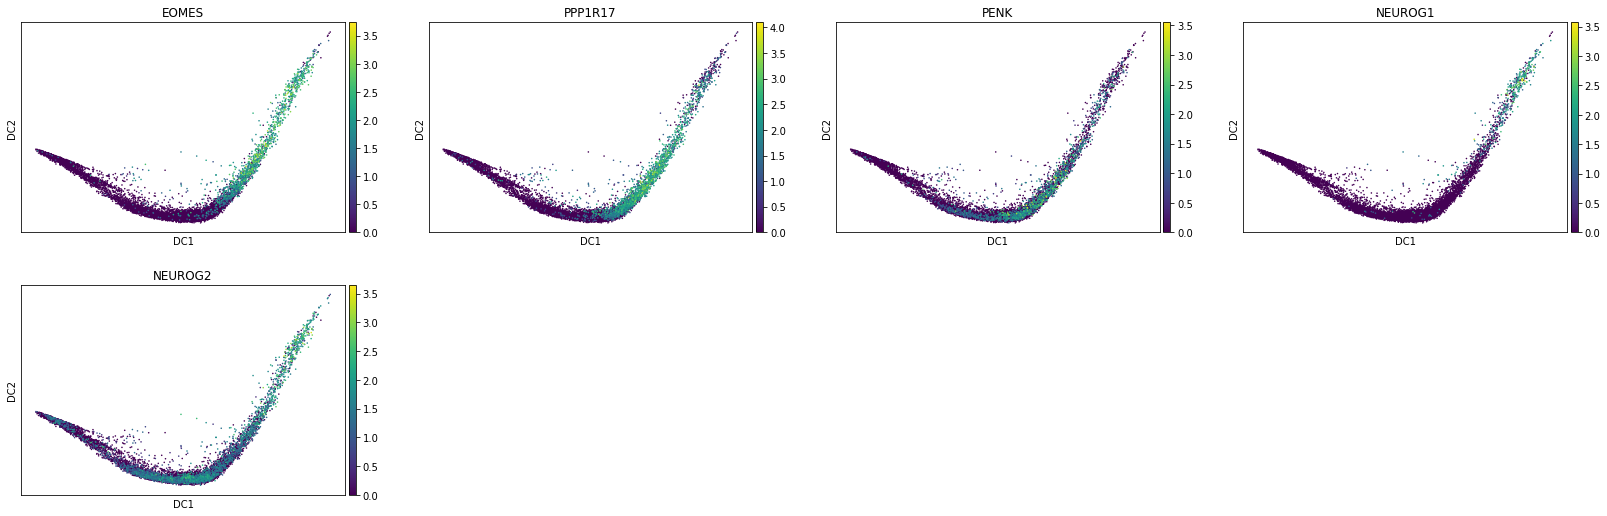

In [41]:
sc.tl.diffmap(ext_rna_adata)
sc.pl.diffmap(ext_rna_adata, color=marker_genes['nIPC'])

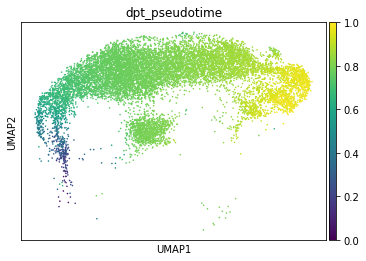

In [42]:
## Define the putative root cell (start of differentiation trajectory)
## we take the maximum for DC1 as the root nIPC
ext_rna_adata.uns['iroot'] = ext_rna_adata.obsm["X_diffmap"][:,1].argmax() 
sc.tl.dpt(ext_rna_adata)
sc.pl.umap(ext_rna_adata, color=["dpt_pseudotime"])

We can already observe different patterns of expression along pseudotime for the GluN marker genes

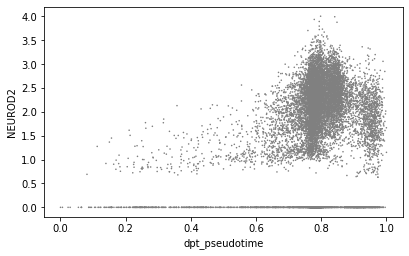

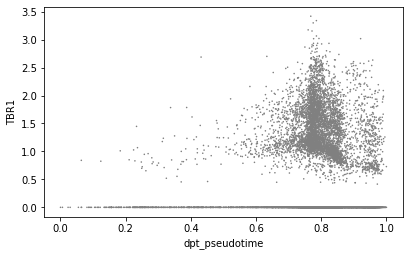

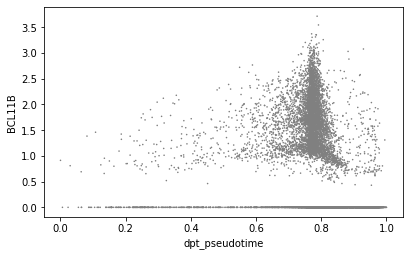

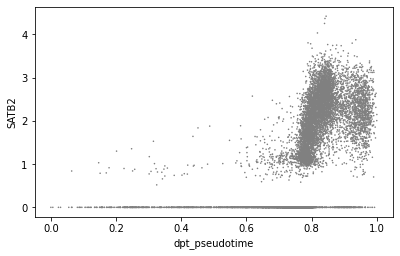

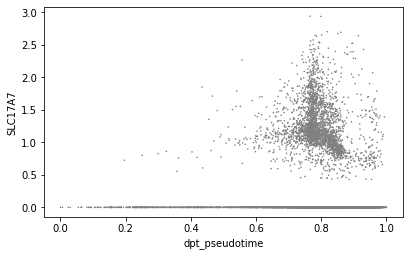

In [43]:
for g in marker_genes["GluN"]:
    sc.pl.scatter(ext_rna_adata, 'dpt_pseudotime', g)

---

## Preprocessing ATAC modality

We are going to use the functions for preprocessing of scATAC data in python implemented in `muon`

In [53]:
from muon import atac as ac

Again, here QC metrics such as the signal at Transcriptional Start Sites and cell and gene filtering were already calculated and used for filtering cells (see implementation in [muon.atac](https://muon.readthedocs.io/en/latest/omics/atac.html)).

Since scATAC data is extremely sparse and most non-zero values in it are 1 and 2, it's common practice to binarize the data matrix.

In [111]:
ac.pp.binarize(atac_adata)

We filter out peaks that are accessible in less than 10 cells 

In [47]:
sc.pp.filter_genes(atac_adata, min_cells=10)

In [48]:
atac_adata

AnnData object with n_obs × n_vars = 6423 × 644347
    obs: 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'Iterative.LSI.Clusters', 'Tss.Enrichment', 'Cell.Barcode', 'TSS.Enrichment.Unsmoothed', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'name', 'classification', 'n_cells'

Now we want to perform dimensionality reduction to visualize our scATAC cells with UMAP. Notably, the stardard PCA on log-normalized used for scRNA-seq data isn't suitable for ATAC data, mainly because there is no good way of selecting "highly variable features" in a binary (or quasi-binary) matrix. Here we will use a simple dimensionality reduction approach called Latent Semantic Indexing (or alternatively Latent Semantic Analysis). Please note that there are several alternative methods/models for dimensionality reduction of scATAC data (e.g. [cisTopic](https://www.nature.com/articles/s41592-019-0367-1), [peakVI](https://www.biorxiv.org/content/10.1101/2021.04.29.442020v1.full), [scOpen](https://www.biorxiv.org/content/10.1101/865931v3)). These are more computationally-intensive, but often show more robust performance than LSI, especially when the data is not exactly squeaky-clean.

With LSI, we normalize the data to minimize the differences driven by total coverage from each cell using a procedure named Term Frequency - Inverse Document Frequency (or TF-IDF). This is a normalization technique adapted from text processing, were we consider each peak as a "term" in a "document" (the cell). This is typically followed by singular value decomposition (SVD) — the same technique that convential principal component analysis (PCA) uses — to generate latent dimensions. The combination of TF-IDF and SVD is referred to as Latent Semantic Indexing (LSI).

TF-IDF normalization is implemented in `muon.atac`.

In [54]:
ac.pp.tfidf(atac_adata, scale_factor=1e4)

In [55]:
## For the PCA step, we can use the standard scanpy function or ac.pp.lsi
# (this can take a while, many features!)
sc.pp.pca(atac_adata)

A word of caution on LSI: typically we see that the first latent factor or the first few latent factors found with this procedure are very strongly correlated with the total counts in the cells. Some workflows suggest excluding these latent factors that simply capture the coverage. In practice, it's not straight-forward to decide which latent factors whould be kept and which should be excluded, so for now we keep them all.

In [57]:
atac_adata.obsm["X_lsi"] = atac_adata.obsm["X_pca"].copy()
atac_adata.obs["LSI_f1"] = atac_adata.obsm["X_lsi"][:,0]
atac_adata.obs["LSI_f2"] = atac_adata.obsm["X_lsi"][:,1]

In [62]:
sc.pp.calculate_qc_metrics(atac_adata, percent_top=None, log1p=False, inplace=True)

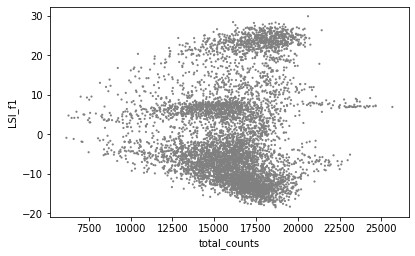

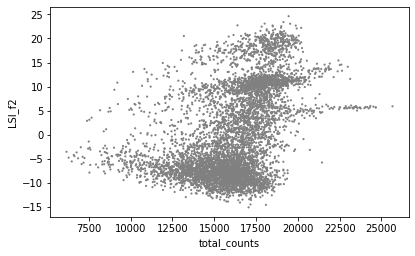

In [63]:
sc.pl.scatter(atac_adata, "total_counts", "LSI_f1")
sc.pl.scatter(atac_adata, "total_counts", "LSI_f2")

We can now compute a KNN graph for clustering and UMAP

In [ ]:
sc.pp.neighbors(atac_adata, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.umap(atac_adata)

In [ ]:
sc.pl.umap(atac_adata, color=["cluster_name"], legend_loc="on data")

Now it's time to start the joint analysis of scRNA and scATAC, where we aim to identify non-coding chromatin regions associated with expression of variable genes during excitatory neuron development.

First off, let's save the progress we've done on the single-modalities in the `.obs` of the multi-omic object container

In [133]:
mdata.update_obs()

In [135]:
# output_dir = /path/to/outdir/
mdata.write("{d}/diagonal_clean.h5mu".format(d=output_dir))

In [10]:
mdata = mu.read("{d}/diagonal_clean.h5mu".format(d=output_dir))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Step 1: Co-embedding to define a pseudotime ordering of the differentiating excitatory neurons from the nIPCs

For this step you will need to find a meaningful common embedding for the cells profiled with different assays. The most common approach to this problem is to first summarise accessibility over gene promoters/bodies, then use a horizontal integration method (i.e. anchoring on the genes) to co-embed the cells from the two assays in the same latent space.

Different pipelines/papers use different strategies to reduce accessibility signal to a gene x cell matrix. 

- Counting fragments over gene bodies and promoters (implemented in [muon](https://muon.readthedocs.io/en/latest/api/generated/muon.atac.tl.count_fragments_features.html?highlight=count_fragments_features) and [Signac](https://satijalab.org/signac/reference/GeneActivity.html))
- [ArchR gene scoring](https://www.archrproject.com/bookdown/calculating-gene-scores-in-archr.html): uses counts over gene bodies and promoter as above, and adds a penalization based on distance of peaks to the genes;
- [Cicero gene activity score](https://cole-trapnell-lab.github.io/cicero-release/docs_m3/##cicero-gene-activity-scores): based on measuring co-accessibility between peaks around a certain gene; 
- [Gene scores from cisTopic](https://www.embopress.org/doi/full/10.15252/msb.20209438): taking the average de-noised accessibility signal from peaks around each gene ([example implementation](https://github.com/emdann/scATAC_prep/blob/master/N2_add_cistopic.ipynb))

Here we provide precomputed gene activities counting fragments over gene bodies and promoters, as implemented by the `Signac` function [`GeneActivity`](https://satijalab.org/signac/reference/geneactivity) (authors of this dataset did not share raw data because of patent privacy). However, feel free to experiment with different options!

In [27]:
gene_activity_data = pd.read_csv('./processed_data/scATAC_clean_gene_activities.csv.gz', 
                                 compression='gzip')
gene_activity_data.index = gene_activity_data['gene']
gene_activity_data = gene_activity_data.drop(['gene'], 1)

For "horizontal-like" multi-omics integration we recommend trying **Seurat CCA** ([vignette](https://satijalab.org/seurat/articles/atacseq_integration_vignette.html)), which has been successfully applied for this task in various studies. 

If you are feeling adventurous, you could try out diagonal integration methods that don't apply any transformation to the features to generate a common embedding. These are more experimental, and will require more parameter tuning. Here is a long and non-exhaustive list of possible tools to try:

- SCIM ([paper](https://academic.oup.com/bioinformatics/article/36/Supplement_2/i919/6055906))([code](https://github.com/ratschlab/scim))
- UINMF ([vignette](http://htmlpreview.github.io/?https://github.com/welch-lab/liger/blob/master/vignettes/UINMF_vignette.html)) - extension of LIGER, requires at least partial overlap (for example by generating a gene-level matrix of accessibility and analyze it together with the peak-accessibility matrix)
- MultiMAP ([code](https://github.com/Teichlab/MultiMAP))
- SCOT ([code](https://github.com/rsinghlab/SCOT))
- bindSC ([paper](https://www.biorxiv.org/content/10.1101/2020.12.11.422014v1.full.pdf))

An additional consideration: should you subset the data to the GluN trajectory before or after co-embedding?

N.B. This task is _hard_, and high-throughput multi-modal data hasn't been around enough for a single or a few methods to establish themselves as the state-of-the-art! If all else fails, remember that you can always take the simpler approach of aggregating cells into cell types that are
confidently identified in both assays, for example by inspection of expression/accessibility of marker genes.

In [1]:
## ...
## your code for co-embedding goes here
## ...

If you decide to go with Seurat CCA, here is some example code to convert your `anndata` objects to Seurat, using R from the Jupyter Notebook using `rpy2`. Remember that once you are done with Seurat, you just need to convert the dimensionality reduction to store in `mdata.obsm` (see also the examples in the [python/R interoperability notebook]()).

In [9]:
## Clean anndatas for faster conversion
atac_adata_seu = mdata["atac"].copy()

del atac_adata_seu.obsp["distances"]
del atac_adata_seu.obsp["connectivities"]
del atac_adata_seu.uns

rna_adata_seu = mdata["rna"].copy()

# del rna_adata_seu.X 
del rna_adata_seu.obsp["distances"]
del rna_adata_seu.obsp["connectivities"]
del rna_adata_seu.uns

In [ ]:
%%R -i rna_adata_seu -i atac_adata_seu
library(Matrix)
atac_adata_seu
rna_adata_seu

In [ ]:
%%R
library(Seurat)
library(Signac)
library(EnsDb.Hsapiens.v86)
library(readr)

## Make Seurat object for RNA 

rna_adata_seu_2 <- CreateSeuratObject(counts=assay(rna_adata_seu, "X"), 
                                      meta.data=data.frame(colData(rna_adata_seu)),
                                      project="brain_chromatin")
# Convert dimensionality reductions
rna_adata_seu_2[["pca"]] <- CreateDimReducObject(embeddings = reducedDim(rna_adata_seu, "PCA"), key = "PCA_", assay = DefaultAssay(rna_adata_seu_2))
rna_adata_seu_2[["umap"]] <- CreateDimReducObject(embeddings = reducedDim(rna_adata_seu, "UMAP"), key = "UMAP_", assay = DefaultAssay(rna_adata_seu_2))

# Identify HVGs
rna_adata_seu_2 <- FindVariableFeatures(rna_adata_seu_2)

In [12]:
%%R -i gene_activity_data
## Make Seurat object for ATAC 

# Rename peaks in ATAC obj
rownames(atac_adata_seu) <- paste0(rowData(atac_adata_seu)[["seqnames"]], "-", rowData(atac_adata_seu)[["start"]], "-", rowData(atac_adata_seu)[["end"]])
atac_assay <- CreateChromatinAssay(
  counts = assay(atac_adata_seu, "X"),
  sep = c("-", "-"),
  genome = "hg38",
  min.cells = 1
)
atac_adata_seu_2 <- CreateSeuratObject(counts = atac_assay, 
                                      meta.data=data.frame(colData(atac_adata_seu)),
                                      project="brain_chromatin",
                                      assay = 'peaks')
# Convert dimensionality reductions
atac_adata_seu_2[["lsi"]] <- CreateDimReducObject(embeddings = reducedDim(atac_adata_seu, "X_lsi"), key = "LSI_", assay = DefaultAssay(atac_adata_seu_2))
atac_adata_seu_2[["umap"]] <- CreateDimReducObject(embeddings = reducedDim(atac_adata_seu, "UMAP"), key = "UMAP_", assay = DefaultAssay(atac_adata_seu_2))

# add gene annotation information
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevelsStyle(annotations) <- "UCSC"
genome(annotations) <- "hg38"
Annotation(atac_adata_seu_2) <- annotations

## Add gene activity matrix 
atac_adata_seu_2[['ACTIVITY']] <- CreateAssayObject(counts = gene_activity_data)

---

Once we have a common embedding, we can use standard similarity-based trajectory inference methods to order the excitatory neurons in pseudotime. For example using the Diffusion Pseudotime implementation in [`sc.tl.dpt`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.dpt.html).

Don't forget to subset to the cells in the excitatory neuron differentiation trajectory! 

In [86]:
mdata.mod["atac"] = mdata["atac"][mdata["atac"].obs["in_GluN_trajectory"]].copy()
mdata.mod["rna"] = mdata["rna"][mdata["rna"].obs["in_GluN_trajectory"]].copy()

mdata.update() ## save filtering changes

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
## ...
## your trajectory inference code goes here
## ...

---

## Step 2: Selecting features for chromatin-expression associations

Now that you have a common embedding and hopefully a common pseudotime axis, we need to select the features that we will use to associate gene expression to chromatin accessibility. We could be greedy and try to test all the possible combinations of genes and peaks, but this would likely be prohibitively computationally expensive (with > 30K genes and > 400k peaks!), not to mention the multiple testing burden we would have. In addition, we know that long range interactions on the genome are possible, but they are not very common, so it doesn't make too much sense to test for associations between genes and chromatin regions that are extremely far apart e.g. on different chromosomes. 

**Feature selection for gene expression:** select a subset of interesting genes that seem to have a dynamic behaviour in the differentiation trajectory. You could select these with standard strategies for variable gene selection (in [R](https://bioconductor.org/books/release/OSCA/feature-selection.html), in [python](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html)), or you could correlate the log-normalized gene expression to the value of pseudotime, to select genes that increase or decrease in expression during differentiation. 

For better approaches to find variable genes in pseudotime, see [tradeSeq](https://bioconductor.org/packages/release/bioc/html/tradeSeq.html) or [cellrank](https://cellrank.readthedocs.io/en/stable/auto_examples/other/plot_model.html#sphx-glr-auto-examples-other-plot-model-py).

**Feature selection for chromatin accessibility:** you'll need to decide _what type of features_ and _which features_ to use at the chromatin level:

- what type of feature: you could use all the peak identified by peak calling, or aggregate counts in peaks that contain the same transcription factor binding motifs (e.g. using [ChromVAR](https://github.com/GreenleafLab/chromVAR)), aggregate counts over peaks in larger genomic windows, collapse counts from co-accessible peaks identified using [Cicero](https://cole-trapnell-lab.github.io/cicero-release/docs_m3/#installing-cicero), any other ideas...?
- which chromatin features should be tested against which genes? Especially if you pick features defined by genomic positions, it's best to subset the possible gene-region pairs to regions within a certain range of the gene. A window of 100k base pairs is often used. See below for an example implementation (in R) to associate genes to peaks in their proximity, using the functionality from [`GenomicRanges`](https://bioconductor.org/packages/release/bioc/vignettes/GenomicRanges/inst/doc/GenomicRangesIntroduction.html).


In [40]:
%%R

## Helper functions 

## String - GRanges conversion
## Borrowed from Signac functions 
## https://satijalab.org/signac/reference/GRangesToString.html
StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}

# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing genomic locations of peaks
# @param features_gr GenomicRanges object containing genomic locations of features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix matching peaks to proximal features (peaks in rows, features in columns)
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix::Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
}

Remember that the peak positions are stored in `mdata.mod["atac"].var` while you can extract genomic locations of the gene bodies using the R package [`ensembldb`](https://bioconductor.org/packages/release/bioc/vignettes/ensembldb/inst/doc/ensembldb.html#4_Retrieving_sequences_for_genetranscriptexon_models)

In [ ]:
## ...
## Your feature selection / peak-gene pairing code goes here
## ...

---

## Step 3: Aggregate expression/accessibility profiles from multiple cells

This step is optional, but highly recommended! In principle, we could test for correlations between gene expression and chromatin accessibility in single-cells (even the the _unmatched assays_ group can impute an accessibility profile for scRNA cells (and viceversa an expression profile for scATAC cells) taking the average profile of nearest neighbors.

However, it's worth thinking about **aggregating profiles from multiple cells**, using clustering or the KNN graph on the common embedding. This is helpful to deal with the high sparsity of the scATAC profiles, to prioritize the most robust associations and to reduce the computational burden of testing for associations. Think of how you could use a common KNN graph for this purpose: You could sample _n_ cells and create pseudobulk profiles from the K-nearest neighbors of those cells (selecting neighbourhoods where there is a sufficient number of cells from both assays in the case of unmatched data). More robust algorithms to sample neighbourhoods on the KNN graph are implemented in [miloR](https://github.com/MarioniLab/miloR) or [MetaCell](https://github.com/tanaylab/metacell). Alternatively, overclustering with the Louvain or Leiden algorithm can be used.


In [5]:
## ...
## Your code for imputation/aggregation goes here
## ...

---

## Step 4: Associating gene expression to accessibility

To test for correlation between gene expression and chromatin accessibility, a common approach is to compute a gene-peak correlation coefficient (Spearman ⍴ or Pearson R2) by correlating normalized scATAC-seq peak peak counts with the corresponding gene’s expression across all ATAC-RNA paired cells. Then the observed coefficient for each gene-peak pair is compared to the coefficients obtained matching the gene to _n_ "background peaks" with matching total accessibility and GC content to the tested one, accounting for technical biases between cells that are caused by PCR amplification or variable Tn5 tagmentation conditions. This results in a null peak-gene correlation distribution that is independent of peak-gene proximity, that can be used for significance testing (for reference see [Ma et al. 2020](https://www.cell.com/cell/fulltext/S0092-8674(20)31253-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867420312538%3Fshowall%3Dtrue), [Kartha et al. 2021](https://www.biorxiv.org/content/10.1101/2021.07.28.453784v1.full)).

The chromVAR package implements simple functions to identify the background peaks:
```R
## In R
library(chromVAR)
library(BSgenome.Hsapiens.UCSC.hg38) ## your reference genome

atac_sce <- readRDS("./processed_data/Multiome_ATAC_ext_trajectory_SCE.RDS")
atac_chromvar_sce <- addGCBias(atac_sce, genome=BSgenome.Hsapiens.UCSC.hg38)
bg <- getBackgroundPeaks(atac_chromvar_sce, niterations = 50) ## This can take a while
```

The ArchR package also provides a [`Peak2GeneLinkage`](https://www.archrproject.com/bookdown/peak2genelinkage-with-archr.html) function to perform a similar mapping (however this only works if you follow their RNA-ATAC integration pipeline from start to finish).

So far out of the ArchR pipeline, there is no well-packaged software tool to test these associations between peaks and genes in single-cell multiomics data. Below we show an example implementation in R, adapting code from [the Buenrostro lab](https://github.com/buenrostrolab/stimATAC_analyses_code).

**Test on a few genes first!** You don't want your code to run for 10 minutes to find out it didn't work at all.


In [ ]:
%%R
## Function to correlate peak expression to gene accessibility
#
# @param rna_sce a SingleCellExperiment object for RNA modality
# @param atac_sce a SingleCellExperiment object for ATAC modality
# @param pairnames a matrix of dimensions 2 * no. of pairs to test, where h 
# 
# @return updated pairnames matrix with an additional column containing 
# the spearman correlation coefficient for the pair
# 
run_p2gene_cor <- function(rna_sce, atac_sce, pairnames){
  pairnames <- as.data.frame(pairnames)
  uniq_peaks <- unique(pairnames[,1])
  uniq_genes <- unique(pairnames[,2])
  
  A = counts(atac_sce) # ATAC matrix
  R = counts(rna_sce) # RNA matrix
  
  all_peaks <- GRangesToString(rowRanges(atac_sce), sep = c(":", "-"))
  uniq_peaks_ixs <- which(all_peaks %in% uniq_peaks)
  uniq_genes_ixs <- which(rownames(R) %in% uniq_genes)
  
  M1 <- as.matrix(Matrix::t(A[uniq_peaks_ixs,,drop=FALSE])) 
  M2 <- as.matrix(Matrix::t(R[uniq_genes_ixs,,drop=FALSE])) 
  
  cormat <- cor(x = M1, y = M2, method = "spearman")
  rownames(cormat) <- uniq_peaks
  colnames(cormat) <- uniq_genes
  cors <- sapply(1:nrow(pairnames), function(i) cormat[pairnames[i,1], pairnames[i,2]])
  pairnames <- cbind(pairnames, cors)
  colnames(pairnames) <- c("peak", "gene", "cor")
  return(pairnames)
}

## Convert the sparse adjacency matrix (output of peak2feature) 
## to a matrix of peak-gene pairings 
pairnames <- cbind(rownames(adj_mat)[adj_mat@i], colnames(adj_mat)[adj_mat@j])

## Filter to a pairings on a single gene for testing
g <- unique(pairnames[,2])[1]
pairnames <- pairnames[pairnames[,2]==g,]

## Compute correlation of true peak-gene pairs
cor_observed <- run_p2gene_cor(rna_sce, atac_sce, pairnames)
colnames(cor_observed)[3] <- "cor_observed"

## Compare to accessibility of background peaks
n_iter = 30 ## how many background peaks to use
sognif_alpha = 0.01 ## Significance threshold for p-values

## Find background peaks
atac_chromvar_sce <- addGCBias(atac_sce[uniq_peaks_ixs,], genome=BSgenome.Hsapiens.UCSC.hg38)
rownames(atac_chromvar_sce) <- uniq_peaks
bg <- getBackgroundPeaks(atac_chromvar_sce, niterations = n_iter) ## This can take a while
rownames(bg) <- rownames(atac_chromvar_sce)

## Find null correlation to background
for (i in 1:n_iter){
  pairnames_bg <- pairnames[,1:2] # Initialize gene-peak pairing to observed
  pairnames_bg[,1] <- uniq_peaks[bg[pairnames[,1],i]] # replace with bg peaks for iteration

  cor_bg_i <- run_p2gene_cor(rna_sce, atac_sce, pairnames_bg)
  cor_observed <- cbind(cor_observed, cor_bg_i[,"cor"] )
  colnames(cor_observed)[ncol(cor_observed)] <- paste0("cor_bg_", i)
  }

## Test for significance 
permCols <- 4:(ncol(bg)+3)
cor_observed_filt <- cor_observed[cor_observed[,"cor_observed"] > 0,]   # Filter to positive correlations
  
# Remove multi-mapping peaks (force 1-1 mapping)
cor_observed_filt <- data.frame(cor_observed_filt) %>% group_by(peak) %>% filter(cor_observed==max(cor_observed))

# # Z test pval
cor_observed_filt$rBgSD <- matrixStats::rowSds(as.matrix(cor_observed_filt[,permCols]))
cor_observed_filt$rBgMean <- rowMeans(cor_observed_filt[,permCols])
cor_observed_filt$pvalZ <- 1-stats::pnorm(q = cor_observed_filt$cor_observed, mean = cor_observed_filt$rBgMean,sd = cor_observed_filt$rBgSD)

## Filter to significant results
signif_cor_observed <- cor_observed_filt[cor_observed_filt$pvalZ < signif_alpha, c("peak","gene","cor_observed","pvalZ")]

In [119]:
## ...
## Your code for testing associations goes here
## ...

How can you assess that your predicted associations make sense? Some ideas:
- Use positive control: e.g. we expect that peaks in the proximity of Transcription Start Sites should be more frequently linked to gene expression.
- Can you define a set of "negative control pairs" where you _don't_ expect to see association?
- Are peaks associated to genes enriched in Transcription Factor motifs? Have a look at [muon functions](https://muon.readthedocs.io/en/latest/api/generated/muon.atac.tl.scan_sequences.html?highlight=motif) and [motifmatchr](http://bioconductor.org/packages/release/bioc/html/motifmatchr.html).

---

## Bonus task
Can you find genes that are likely to be affected by mutations associated with in Autism Spectrum Disorder? Annotations for curated ASD linked loci [here](https://drive.google.com/file/d/19KzfFRpYCMrcq1gHTsFrsGdR_5cnj3HW/view?usp=sharing).

In [1]:
## ...
## your code goes here
## ...

---